In [1]:
import torch
from torch import nn

In [2]:
from scripts import muat_datasets
from pathlib import Path

data_path = Path('datasets')
train_dir, test_dir = muat_datasets.muat_data(data_path)

Path dataset sudah benar!


In [3]:
train_dir, test_dir

(WindowsPath('datasets/train'), WindowsPath('datasets/test'))

Direktori gambar: datasets\train\red_rot\redrot (143).jpeg
Class gambar: red_rot
Tinggi gambar: 918
Lebar gambar: 750


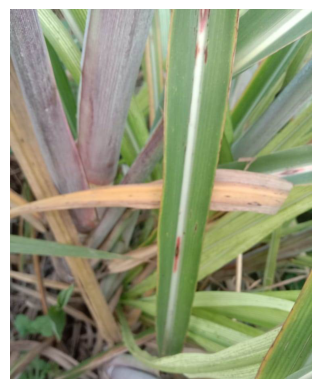

In [4]:
from scripts import visualization

visualization.cek_gambar(data_path)

In [5]:
import torchvision

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
weights = torchvision.models.Swin_V2_B_Weights.DEFAULT
weights

Swin_V2_B_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[256]
    resize_size=[272]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
from torchvision.transforms import v2

In [10]:
train_transform = v2.Compose([
    v2.Resize(size = [256, 256]),
    # v2.Grayscale(num_output_channels = 1),
    v2.AugMix(),
    v2.TrivialAugmentWide(num_magnitude_bins = 31),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(size = [256, 256]),
    # v2.Grayscale(num_output_channels = 1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [11]:
train_data_loader, test_data_loader, class_names = muat_datasets.dataLoader(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            batch_size = 32, num_workers = 4,
                                                                            train_transform = train_transform,
                                                                            test_transform = test_transform)
train_data_loader, test_data_loader, class_names

Membuat DataLoader dengan ukuran batch 32 dan 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2cf2aa6c5f0>,
 ['healthy', 'mosaic', 'red_rot', 'rust', 'yellow'])

In [12]:
image_batch, label_batch = next(iter(train_data_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape gambar: torch.Size([3, 256, 256])
Class gambar (bentuk angka): 0


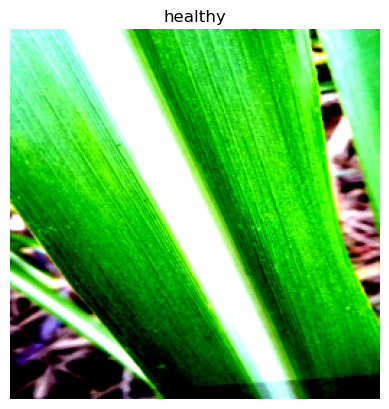

In [13]:
visualization.cek_gambar_dl(image_batch = image_batch, label_batch = label_batch, class_names = class_names)

# SWIN Transformer Step-by-Step

In [14]:
model = torchvision.models.swin_v2_b(weights = weights).to(device)

In [15]:
from torchinfo import summary

In [16]:
summary(model = model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 7, 7, 1024]     --                   True
│    └─Sequential (0)                                   [32, 3, 224, 224]    [32, 56, 56, 128]    --                   True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 128, 56, 56]    6,272                True
│    │    └─Permute (1)                                 [32, 128, 56, 56]    [32, 56, 56, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 56, 56, 128]    [32, 56, 56, 128]    256                  True
│    └─Sequential (1)                                   [32, 56, 56, 128]    [32, 56, 56, 128]    --                   True
│    

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
from scripts import helper

In [19]:
helper.set_seeds()

output_shape = len(class_names)

model.head = torch.nn.Sequential(
    torch.nn.Linear(in_features=1024, 
                    out_features = output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [20]:
summary(model = model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 7, 7, 1024]     --                   False
│    └─Sequential (0)                                   [32, 3, 224, 224]    [32, 56, 56, 128]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 128, 56, 56]    (6,272)              False
│    │    └─Permute (1)                                 [32, 128, 56, 56]    [32, 56, 56, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 56, 56, 128]    [32, 56, 56, 128]    (256)                False
│    └─Sequential (1)                                   [32, 56, 56, 128]    [32, 56, 56, 128]    --                   Fal

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [22]:
from scripts import engine
# Set the random seeds
helper.set_seeds()

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader = train_data_loader,
                       test_dataloader = test_data_loader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total waktu train: {end_time-start_time:.3f} detik')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1628 | train_acc: 0.5689 | test_loss: 1.0883 | test_acc: 0.6035
Epoch: 2 | train_loss: 0.7770 | train_acc: 0.7485 | test_loss: 0.9192 | test_acc: 0.6926
Epoch: 3 | train_loss: 0.6683 | train_acc: 0.7664 | test_loss: 0.8271 | test_acc: 0.7113
Epoch: 4 | train_loss: 0.5978 | train_acc: 0.8111 | test_loss: 0.8884 | test_acc: 0.6879
Epoch: 5 | train_loss: 0.5680 | train_acc: 0.8111 | test_loss: 0.8212 | test_acc: 0.6891
Epoch: 6 | train_loss: 0.5202 | train_acc: 0.8221 | test_loss: 0.7204 | test_acc: 0.7461
Epoch: 7 | train_loss: 0.4812 | train_acc: 0.8472 | test_loss: 0.6979 | test_acc: 0.7609
Epoch: 8 | train_loss: 0.4692 | train_acc: 0.8506 | test_loss: 0.7518 | test_acc: 0.7285
Epoch: 9 | train_loss: 0.4489 | train_acc: 0.8481 | test_loss: 0.7477 | test_acc: 0.7441
Epoch: 10 | train_loss: 0.4310 | train_acc: 0.8590 | test_loss: 0.6613 | test_acc: 0.7660
Epoch: 11 | train_loss: 0.4270 | train_acc: 0.8504 | test_loss: 0.7105 | test_acc: 0.7496
Epoch: 12 | train_l

In [23]:
PATH = Path('model')
MODEL_NAME = 'SwinV2_daun_tebu_AugMix_TrivialAW_Norm.pth'

SAVE_PATH = PATH/MODEL_NAME

In [24]:
print(f'Saving model to: {SAVE_PATH}')
torch.save(obj = model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f = SAVE_PATH)

Saving model to: model\SwinV2_daun_tebu_AugMix_TrivialAW_Norm.pth


In [25]:
custom_img_path = Path('datasets/test/healthy/healthy (3).jpeg')

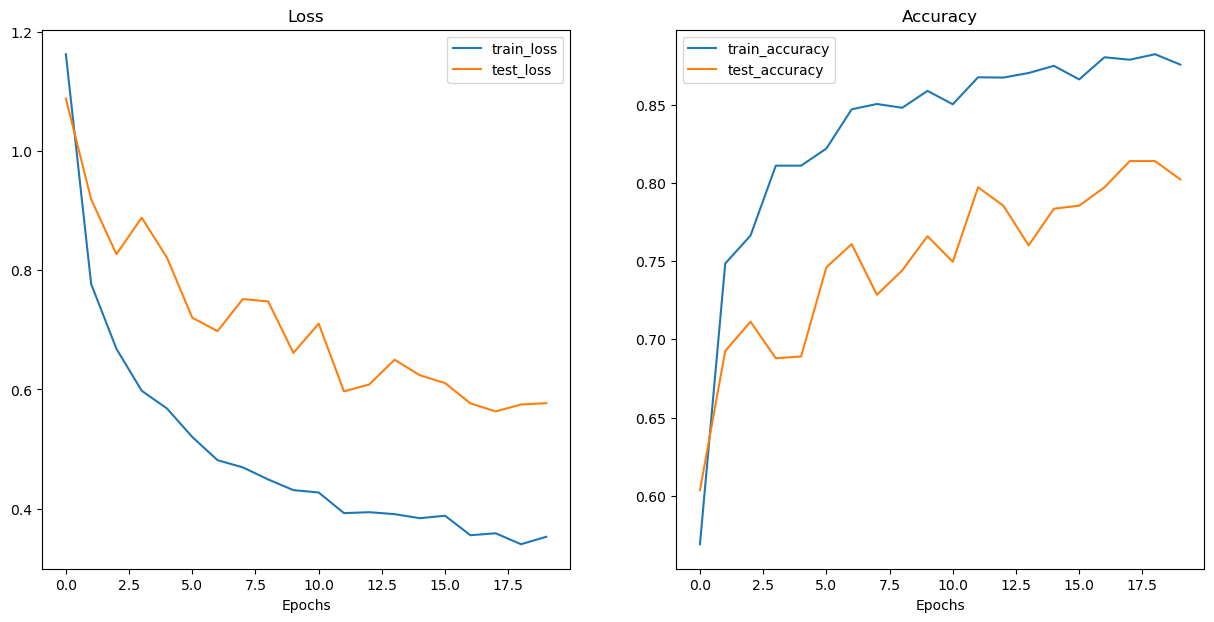

In [26]:
from scripts import prediksi
prediksi.plot_grafik_loss(results)

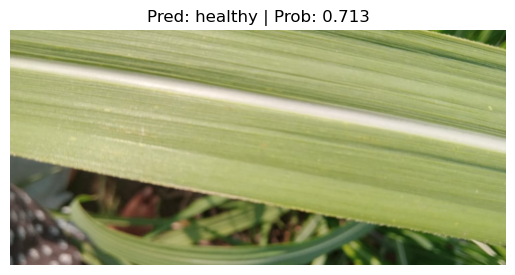

In [27]:
prediksi.pred_gambar(model = model,
                image_path = custom_img_path,
                class_names=class_names,
                transform = test_transform,
                device = device)

  0%|          | 0/16 [00:00<?, ?it/s]

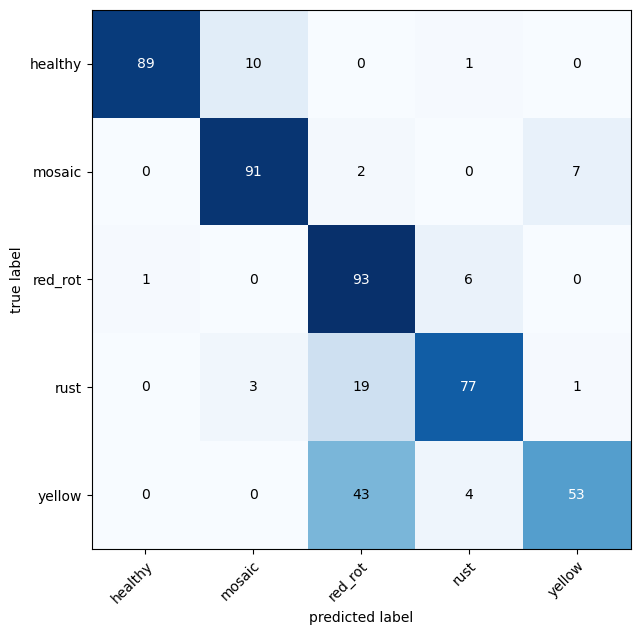

In [28]:
prediksi.confusion_matrix(
    model = model,
    test_dataloader = test_data_loader,
    device = device,
    class_names = class_names
)